# Introduction

In medical imaging, particularly when working with DICOM files, adding annotations like bounding boxes can be crucial for enhancing the interpretability of images, aiding in diagnostic processes, and facilitating communication between healthcare professionals. However, traditional DICOM images are often grayscale, and directly overlaying annotations on them can be challenging.

This Google Colab notebook addresses this challenge by guiding you through the process of converting grayscale DICOM images to RGB format.

# Install dependencies

Python has a library called pydicom which is is a pure python package for parsing DICOM files.

https://pypi.org/project/pydicom/0.9.7/

In [6]:
!pip install pydicom
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut, apply_modality_lut
import matplotlib.pyplot as plt
import cv2

# Utility Functions

In [8]:
def min_max_scale(img):
    maxv = img.max()
    minv = img.min()
    if maxv > minv:
        return (img - minv) / (maxv - minv)
    else:
        return img - minv  # ==0

def preprocess_dicom(arr, ds):
    """
    Function applies the following:
    Rescale with Modality LUT or slope and intercept
    VOI or Windowing
    Fix the photometric interpretation
    Normalize between 0 and 255: convert to 8-bits pixel values

    Parameters
    ----------
    arr : numpy.ndarray
    ds : dataset.Dataset

    Returns
    -------
    numpy.ndarray
        An array with applied multiple grayscale transformations
    """
    arr = apply_modality_lut(arr, ds)
    arr = arr.astype(np.uint16)
    arr = apply_voi_lut(arr, ds, index=0)
    if ds.BitsAllocated != 8:
        arr = min_max_scale(arr)
        arr = arr * 255

    arr = arr.astype(np.uint8)
    if ds.PhotometricInterpretation == 'MONOCHROME1':
        arr = 255 - arr

    return arr


def draw_boxes(boxes, image, color=(255, 0, 0), thickness=10):
    for i, box in enumerate(boxes):
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
        )

    return image


def dicom_gray2rgb(arr, ds, birads, color=(255, 0, 0), bboxes=None):
    """
    Coverts grayscale dicom to rgb, draws bounding boxes of lesion areas, adds birads tag

    Parameters
    ----------
    arr : numpy.ndarray
    ds : dataset.Dataset
    birads: int
    color: tuple
    bboxes: list of lists, eg. [[xmin, ymin, xmax, ymax],[xmin, ymin, xmax, ymax]]

    Returns
    -------
    ds : dataset.Dataset
    """

    # Gray to rgb
    arr = cv2.cvtColor(arr, cv2.COLOR_GRAY2RGB)
    # Draw bounding boxes
    if bboxes:
        arr = draw_boxes(bboxes, arr, color=color)
    # Get laterality to know where add birads tag
    laterality = ds.get('ImageLaterality', ds.get('SeriesDescription'))
    text = f'BI-RADS:{birads}'
    # add birads tag
    if laterality.startswith('L'):
        cv2.putText(arr, text, (arr.shape[1] - 1000, 500), cv2.FONT_HERSHEY_SIMPLEX, 5, color, 10)
    elif laterality.startswith('R'):
        cv2.putText(arr, text, (200, 500), cv2.FONT_HERSHEY_SIMPLEX, 5, color, 10)
    else:
        cv2.putText(arr, text, (arr.shape[1] // 2, 500), cv2.FONT_HERSHEY_SIMPLEX, 5, color, 10)

    # For compressed pixel data that will be written decompressed:
    if ds.file_meta.TransferSyntaxUID.is_compressed is True:
        ds.decompress()

    # Update the DICOM tags according to RGB format
    ds.PhotometricInterpretation = 'RGB'
    ds.SamplesPerPixel = 3  # RGB has 3 samples (R, G, B)
    # Update the pixel data
    ds.BitsAllocated = 8  # Change to 8 bits
    ds.BitsStored = 8  # Change to 8 bits
    ds.HighBit = 7  # (2^7 - 1) = 255 for 8-bit images
    # Update windowing
    ds.WindowWidth = 256
    ds.WindowCenter = 128
    # Add Planar Configuration
    ds.add_new(0x00280006, 'US', 0)

    # Delete tags that where used while preprocesing dicom and we don't need them anymore
    if ds.get('VOILUTSequence'):
        del ds['VOILUTSequence']

    if ds.get('RescaleSlope'):
        del ds['RescaleSlope']

    if ds.get('RescaleIntercept'):
        del ds['RescaleIntercept']

    # Overwrite the pixel data
    ds.PixelData = arr.tobytes()
    return ds

# Convert Greyscale to RGB

## Preprocess Raw Pixel Data

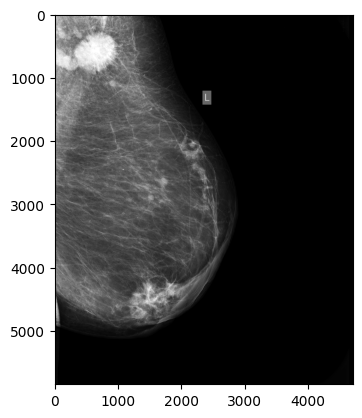

In [5]:
ds = pydicom.dcmread('/content/233019_5.dcm')
arr = ds.pixel_array
arr = preprocess_dicom(arr, ds)
plt.imshow(arr, cmap='gray')

## Draw bounding boxes and save dicom as rgb

In [9]:
# for this particular example
bboxes = [[351, 247, 1061, 879], [1214, 4291, 1724, 4807]]
birads = 5
color = (255, 5, 5)
ds_modified = dicom_gray2rgb(arr, ds, birads, color, bboxes)

# Save the DICOM file with the modified pixel data to a new file
ds_modified.save_as('dicom_rgb.dcm')

## Visualization
The appended desktop screenshot from a DICOM viewer serves as a visual testament to the successful transformation of grayscale DICOM images to RGB format with added bounding boxes.

(-0.5, 1214.5, 737.5, -0.5)

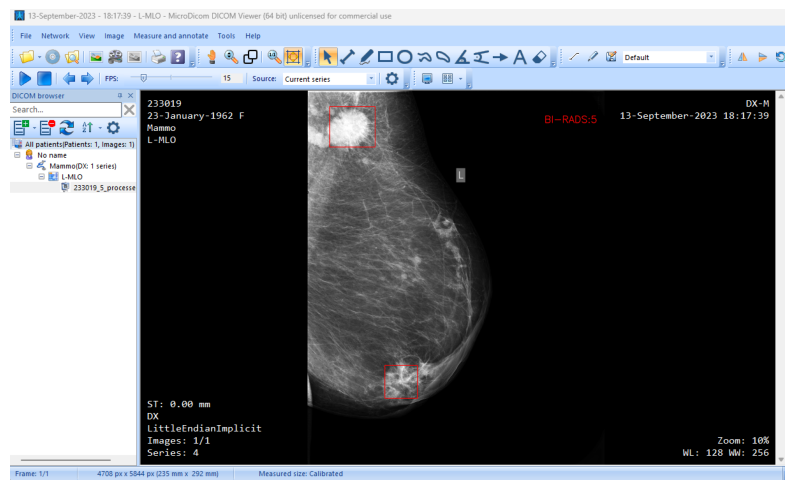

In [19]:
img = cv2.imread('/content/dicom_rgb.png')
img = img[...,::-1]
plt.figure(figsize=(10,15))
plt.imshow(img)
plt.axis('off')